# Environment

In [10]:
import os
import gc
import sys
import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad
import seaborn as sns
import scipy.sparse as sp
import matplotlib.pyplot as plt
from scipy.sparse import issparse
import plotly.graph_objects as go
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed
from IPython.display import display, clear_output

os.chdir('/home/michal.kubacki/Githubs/GeneScore/Amin_dataset_scorring')

from dotenv import load_dotenv
load_dotenv()
sys.path.insert(0, os.getenv('PROJECT_FUNCTIONS_PATH'))

from evaluated_helpers import (
    load_GRNs_gene_sets,
    remove_duplicates_preserve_order_GRNs
)

from gene_scoring import score_genes

In [11]:
sc.settings.verbosity = 3
sc.settings.set_figure_params(dpi=80)

In [12]:
data_path = os.getenv('DATA_PATH')
root_dir = os.getenv('ROOT_DIR')

In [13]:
input_file = os.path.join(data_path, '3_FiltNormAdata.h5ad')
output_file = os.path.join(data_path, '4_GeneScores.h5ad')

In [14]:
gpu_support = False
recompute = True

In [15]:
gene_sets = ['L2-3_CUX2']
cell_types = ['L2-3_CUX2']
gois = ['AHR', 'AR', 'NR1I2', 'NR1I3', 'NR3C1', 'NR3C2', 'ESR1', 'RARA', 'ESR2', 'THRB', 'THRA']
control_condition = 'LDN'
conditions = ['FGF2-50', 'FGF2-20', 'FGF4', 'FGF8'] # FGF pathway
conditions += ['SAG1000', 'SAG250'] # SAG pathway
conditions += ['BMP4'] # BMP4 pathway
conditions += ['BMP7'] # BMP7 pathway
conditions += ['CHIR3', 'CHIR1.5'] # WNT pathway
conditions += ['IWP2'] # IWP2 pathway
conditions += ['RA100', 'RA10'] # Retinoic acid pathway
conditions += [control_condition]

# Load Data

## GRNs

In [16]:
_, gene_sets_dict_cell_type_first = load_GRNs_gene_sets(root_dir=root_dir, gene_set_list=gene_sets)

In [17]:
for cell_type, cell_type_dict in gene_sets_dict_cell_type_first.items():
    for gene_set, gene_dict in cell_type_dict.items():
        
        # SAG pathway genes
        print("\nSAG pathway genes:")
        for gene in ['GLI1', 'GLI2', 'GLI3', 'GLI4']:
            if gene in gene_dict:
                print(f"\nGene: {gene}")
                print("Targets:", gene_dict[gene]['targets'])
        
        # Retinoic Acid pathway genes
        print("\nRetinoic Acid pathway genes:")
        for gene in ['RARA', 'RARB', 'RARG', 'RXRA', 'RXRB', 'RXRG']:
            if gene in gene_dict:
                print(f"\nGene: {gene}")
                print("Targets:", gene_dict[gene]['targets'])


SAG pathway genes:

Gene: GLI1
Targets: ['MGST1', 'DHFR']

Gene: GLI2
Targets: ['NCAM2', 'ASTN2', 'SAMD3', 'ZNF804A', 'NRGN', 'MGST1', 'DGKB', 'NKAIN3', 'MAN1A1', 'TUBB2A', 'PCSK5', 'TOX3', 'RPS6KA5', 'NNAT', 'ALCAM', 'AKAP13', 'BACH2', 'BMPR1B', 'PDE1A', 'CTBP2', 'FIGN', 'NR3C2']

Gene: GLI3
Targets: ['NNAT', 'DHFR', 'EFNA5', 'TXNDC16', 'HS3ST4', 'FOXG1', 'KIAA1211', 'ALCAM', 'SQLE', 'BMPR1B', 'TRIM36', 'NCAM2', 'NFIB', 'ITPR2', 'MSI2', 'NR3C2', 'SCD']

Gene: GLI4
Targets: ['TMSB4X', 'NREP']

Retinoic Acid pathway genes:

Gene: RARA
Targets: ['ABHD3', 'KIAA1211', 'C1QTNF4', 'HSPA4L', 'PRKD1', 'MAK', 'RBM25', 'OXR1', 'HSP90AA1', 'NRGN', 'DNAJB1', 'FGD4', 'PTPRZ1']

Gene: RARB
Targets: ['PTPRZ1', 'PRKD1', 'MAML3', 'KIAA1211', 'KIF26B', 'STMN1', 'FGFR2', 'ANTXR1']

Gene: RARG
Targets: ['PCDH15', 'AFF2', 'PRKD1', 'KIAA1211']

Gene: RXRA
Targets: ['RIT2', 'PCDH7', 'PCDH9', 'ALCAM', 'NREP', 'CLSTN2', 'FAM13A', 'CLMP', 'PCSK1N', 'OXR1', 'PTPRZ1', 'SEMA3C', 'CXXC4', 'KAZN', 'LINGO2', 'CDH13'

In [18]:
for cell_type, cell_type_dict in gene_sets_dict_cell_type_first.items():
    for gene_set, gene_dict in cell_type_dict.items():
        
        # Initialize pathway dictionaries
        pathways = {
            'SAG': {'targets': {}, 'weights': {}},
            'RA': {'targets': {}, 'weights': {}}
        }
        
        # Group SAG pathway genes
        for gene in ['GLI1', 'GLI2', 'GLI3', 'GLI4']:
            if gene in gene_dict:
                for target, weight in zip(gene_dict[gene]['targets'], gene_dict[gene]['scored_coef_mean']):
                    if target not in pathways['SAG']['weights']:
                        pathways['SAG']['weights'][target] = []
                    pathways['SAG']['weights'][target].append(weight)
        
        # Group Retinoic Acid pathway genes  
        for gene in ['RARA', 'RARB', 'RARG', 'RXRA', 'RXRB', 'RXRG']:
            if gene in gene_dict:
                for target, weight in zip(gene_dict[gene]['targets'], gene_dict[gene]['scored_coef_mean']):
                    if target not in pathways['RA']['weights']:
                        pathways['RA']['weights'][target] = []
                    pathways['RA']['weights'][target].append(weight)
        
        # Average weights for repeated targets
        for pathway in ['SAG', 'RA']:
            pathways[pathway]['targets'] = list(pathways[pathway]['weights'].keys())
            pathways[pathway]['weights'] = [np.mean(weights) for weights in pathways[pathway]['weights'].values()]
        
        print(f"\nCell type: {cell_type}, Gene set: {gene_set}")
        print("\nSAG pathway:")
        print("Number of targets:", len(pathways['SAG']['targets']))
        print("Average weight:", np.mean(pathways['SAG']['weights']) if pathways['SAG']['weights'] else 0)
        
        print("\nRetinoic Acid pathway:")
        print("Number of targets:", len(pathways['RA']['targets']))
        print("Average weight:", np.mean(pathways['RA']['weights']) if pathways['RA']['weights'] else 0)


Cell type: L2-3_CUX2, Gene set: L2-3_CUX2

SAG pathway:
Number of targets: 36
Average weight: -0.29379949277500494

Retinoic Acid pathway:
Number of targets: 48
Average weight: 0.34235605358624976


## Transcriptomics data

### Load

In [19]:
adata = sc.read_h5ad(input_file)
adata.var_names_make_unique()

In [20]:
adata

AnnData object with n_obs × n_vars = 36252 × 19633
    obs: 'Og_sample', 'Og_bc_index', 'Og_species', 'Og_tscp_count', 'Og_tscp_count_50dup', 'Og_gene_count', 'Og_quality', 'Og_condition', 'run_id', 'sample_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'gene_UMI_ratio', 'log1p_gene_UMI_ratio', 'n_genes', 'n_counts', 'class', 'class2', 'region', 'Leiden_01', 'Leiden_02', 'Leiden_03', 'Leiden_04', 'Leiden_05', 'Leiden_06', 'Leiden_08', 'Leiden_10', 'Leiden_12', 'Leiden_Sel'
    var: 'gene_id', 'genome', 'gene_name_unique', 'mito', 'ribo', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'Leiden_01_colors', 'Leiden_02_colors', 'Leiden_03_colors', 'Leiden_04_color

In [21]:
print(list(adata.obs['class'].unique()))
print(list(adata.obs['class2'].unique()))

['neuron', 'choroid', 'progenitor', 'IPC', nan, 'astroglia', 'oligo']
['neuron.glut1', 'choroid', 'progenitor', 'IPC', 'neuron.glut2', 'neuron.gaba', 'neuron.mixed', nan, 'astroglia', 'neuron.dop', 'OPC', 'oligo']


### Subset

In [22]:
neurons = adata[adata.obs['class2'].isin(['neuron.glut1', 'neuron.glut2'])]

In [23]:
neurons = neurons[neurons.obs['Og_condition'].isin(conditions)]

In [24]:
neurons

View of AnnData object with n_obs × n_vars = 2883 × 19633
    obs: 'Og_sample', 'Og_bc_index', 'Og_species', 'Og_tscp_count', 'Og_tscp_count_50dup', 'Og_gene_count', 'Og_quality', 'Og_condition', 'run_id', 'sample_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'gene_UMI_ratio', 'log1p_gene_UMI_ratio', 'n_genes', 'n_counts', 'class', 'class2', 'region', 'Leiden_01', 'Leiden_02', 'Leiden_03', 'Leiden_04', 'Leiden_05', 'Leiden_06', 'Leiden_08', 'Leiden_10', 'Leiden_12', 'Leiden_Sel'
    var: 'gene_id', 'genome', 'gene_name_unique', 'mito', 'ribo', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'Leiden_01_colors', 'Leiden_02_colors', 'Leiden_03_colors', 'Leiden_0

In [25]:
print(neurons.obs.Og_condition.nunique(), ": ",list(neurons.obs.Og_condition.unique()))

13 :  ['FGF8', 'LDN', 'CHIR1.5', 'BMP7', 'FGF4', 'IWP2', 'FGF2-20', 'RA10', 'CHIR3', 'FGF2-50', 'RA100', 'SAG1000', 'SAG250']


In [26]:
neurons.layers['counts'].toarray()

array([[0., 1., 2., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 2., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 2., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [27]:
neurons.X.toarray()

array([[0.        , 0.5253986 , 0.86805195, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.87906605, 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 2.662588  , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]], dtype=float32)

### Agreggate

In [28]:
# Convert Categorical columns to string and create a combined condition column
neurons.obs['class2_str'] = neurons.obs['class2'].astype(str)
neurons.obs['Og_condition_str'] = neurons.obs['Og_condition'].astype(str)
neurons.obs['combined_condition'] = neurons.obs['class2_str'].str.cat(neurons.obs['Og_condition_str'], sep='-')

combined_conditions = neurons.obs['combined_condition'].unique()
aggr_data = []

for cond in combined_conditions:
    subset = neurons[neurons.obs['combined_condition'] == cond]
    aggr_data.append(subset.layers['counts'].sum(axis=0))

# Create a new AnnData object with aggregated data
neurons_aggr = sc.AnnData(X=np.vstack(aggr_data),
                               obs=pd.DataFrame(index=combined_conditions, columns=['combined_condition']),
                               var=neurons.var)

neurons_aggr.obs['combined_condition'] = combined_conditions

# Split the combined condition back into class2 and Og_condition
split_conditions = neurons_aggr.obs['combined_condition'].str.split('-', n=1, expand=True)
if split_conditions.shape[1] == 2:
    neurons_aggr.obs['class2'] = split_conditions[0]
    neurons_aggr.obs['Og_condition'] = split_conditions[1]
else:
    print("Warning: Some combined conditions don't contain the '-' separator.")
    neurons_aggr.obs['class2'] = split_conditions[0]
    neurons_aggr.obs['Og_condition'] = ''

# Normalize for sequencing depth
sc.pp.normalize_total(neurons_aggr, target_sum=1e6)  # Normalize to counts per million (CPM)

/localscratch/18756186.michal.kubacki/ipykernel_229139/3704655439.py:2: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  neurons.obs['class2_str'] = neurons.obs['class2'].astype(str)


normalizing counts per cell
    finished (0:00:00)


In [29]:
gc.collect()

305

# Scoring

In [30]:
if sp.issparse(neurons_aggr.X):
    X_array = neurons_aggr.X.toarray()
else:
    X_array = np.array(neurons_aggr.X)

In [31]:
neurons_aggr.X = X_array

In [32]:
gc.collect()

0

In [33]:
if recompute:
    for control in [True, False]:
        for control_condition in [control_condition, None]:
            for normalize_weights in [True, False]:
                for scaling_only_based_on_control in [True, False]: 
                    for scale_by_variance in [True, False]:
                        for pathway in list(pathways.keys()):
                            try:
                                score_genes(
                                    neurons_aggr,
                                    gene_list=pathways[pathway]['targets'], 
                                    gene_weights=pathways[pathway]['weights'],   
                                    score_name = (
                                        f'gene_score_{pathway}_{control}_'
                                        f'normalized_{normalize_weights}_'
                                        f'scaled_{scale_by_variance}_'
                                        f'cc_{control_condition}_'
                                        f'sc_{scaling_only_based_on_control}'
                                    ),                                   
                                    ctrl_size=50,
                                    gene_pool=None,
                                    n_bins=25,
                                    random_state=0,
                                    copy=False,
                                    used_layer=None,
                                    return_scores=False,
                                    control=control,
                                    weighted=True,
                                    abs_diff=False,
                                    gpu=gpu_support,
                                    chunk_size=10000,
                                    disable_chunking=True,
                                    scale_by_variance=scale_by_variance,
                                    normalize_weights=normalize_weights,
                                    conditions_labels='Og_condition',
                                    control_condition=control_condition,
                                    debug=True,
                                    scaling_only_based_on_control=scaling_only_based_on_control
                                )
                            except IndexError as e:
                                print(f"Index   Error occurred for {pathway}: {str(e)}")
                                continue

In [34]:
neurons_aggr

AnnData object with n_obs × n_vars = 22 × 19633
    obs: 'combined_condition', 'class2', 'Og_condition', 'gene_score_SAG_True_normalized_True_scaled_True_cc_LDN_sc_True', 'gene_score_RA_True_normalized_True_scaled_True_cc_LDN_sc_True', 'gene_score_SAG_True_normalized_True_scaled_False_cc_LDN_sc_True', 'gene_score_RA_True_normalized_True_scaled_False_cc_LDN_sc_True', 'gene_score_SAG_True_normalized_True_scaled_True_cc_LDN_sc_False', 'gene_score_RA_True_normalized_True_scaled_True_cc_LDN_sc_False', 'gene_score_SAG_True_normalized_True_scaled_False_cc_LDN_sc_False', 'gene_score_RA_True_normalized_True_scaled_False_cc_LDN_sc_False', 'gene_score_SAG_True_normalized_False_scaled_True_cc_LDN_sc_True', 'gene_score_RA_True_normalized_False_scaled_True_cc_LDN_sc_True', 'gene_score_SAG_True_normalized_False_scaled_False_cc_LDN_sc_True', 'gene_score_RA_True_normalized_False_scaled_False_cc_LDN_sc_True', 'gene_score_SAG_True_normalized_False_scaled_True_cc_LDN_sc_False', 'gene_score_RA_True_normali

# Plots

In [35]:
SAG_conditions = ['LDN', 'SAG250', 'SAG1000'] # SAG pathway
RA_conditions = ['LDN', 'RA10', 'RA100'] # Retinoic acid pathway


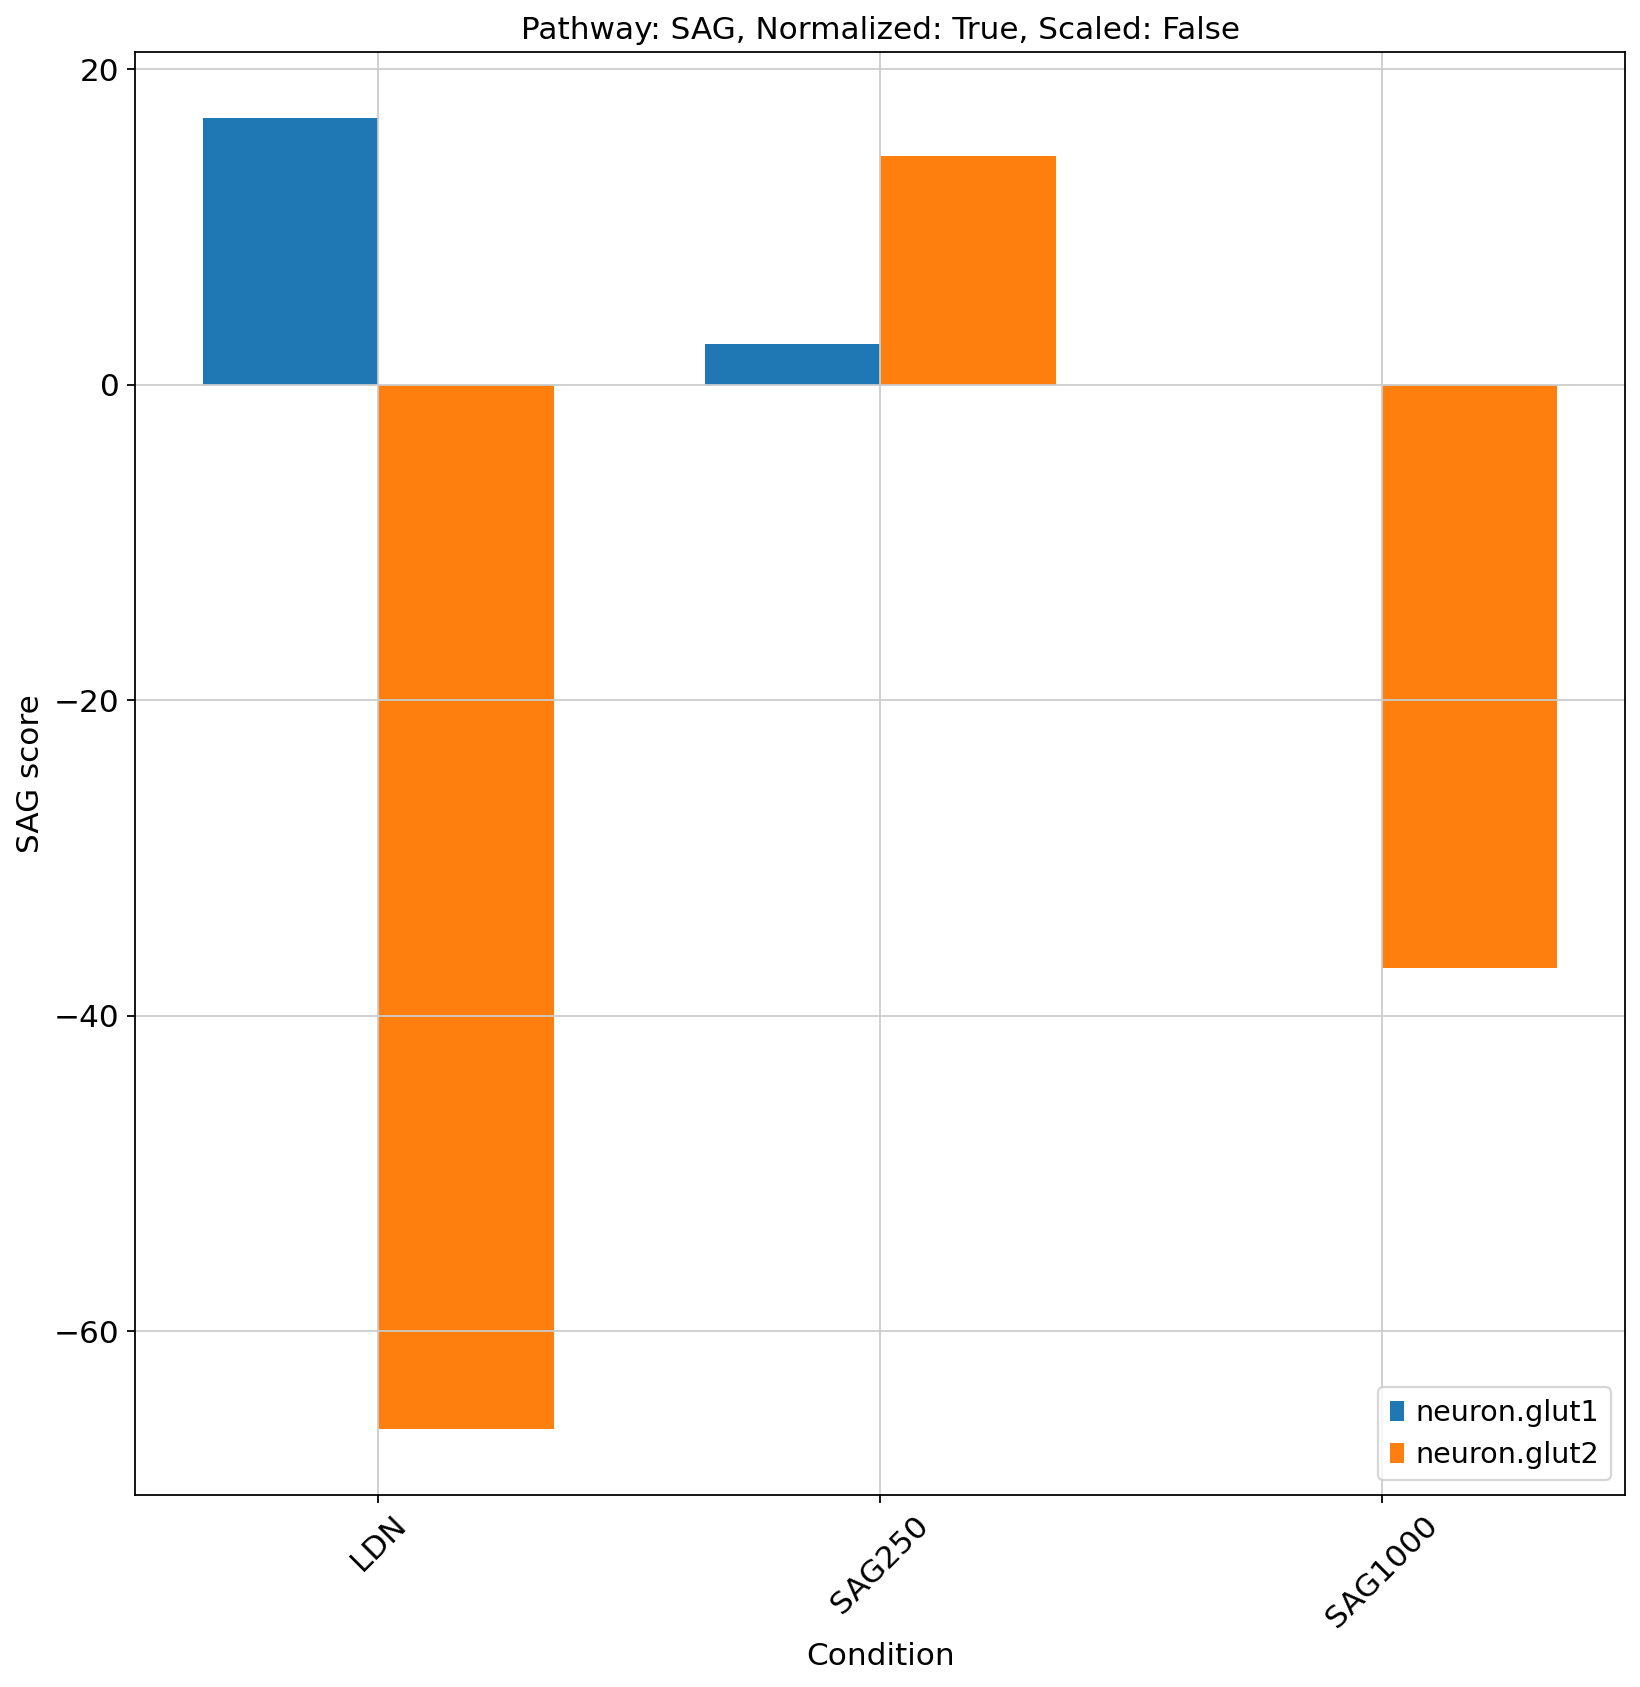

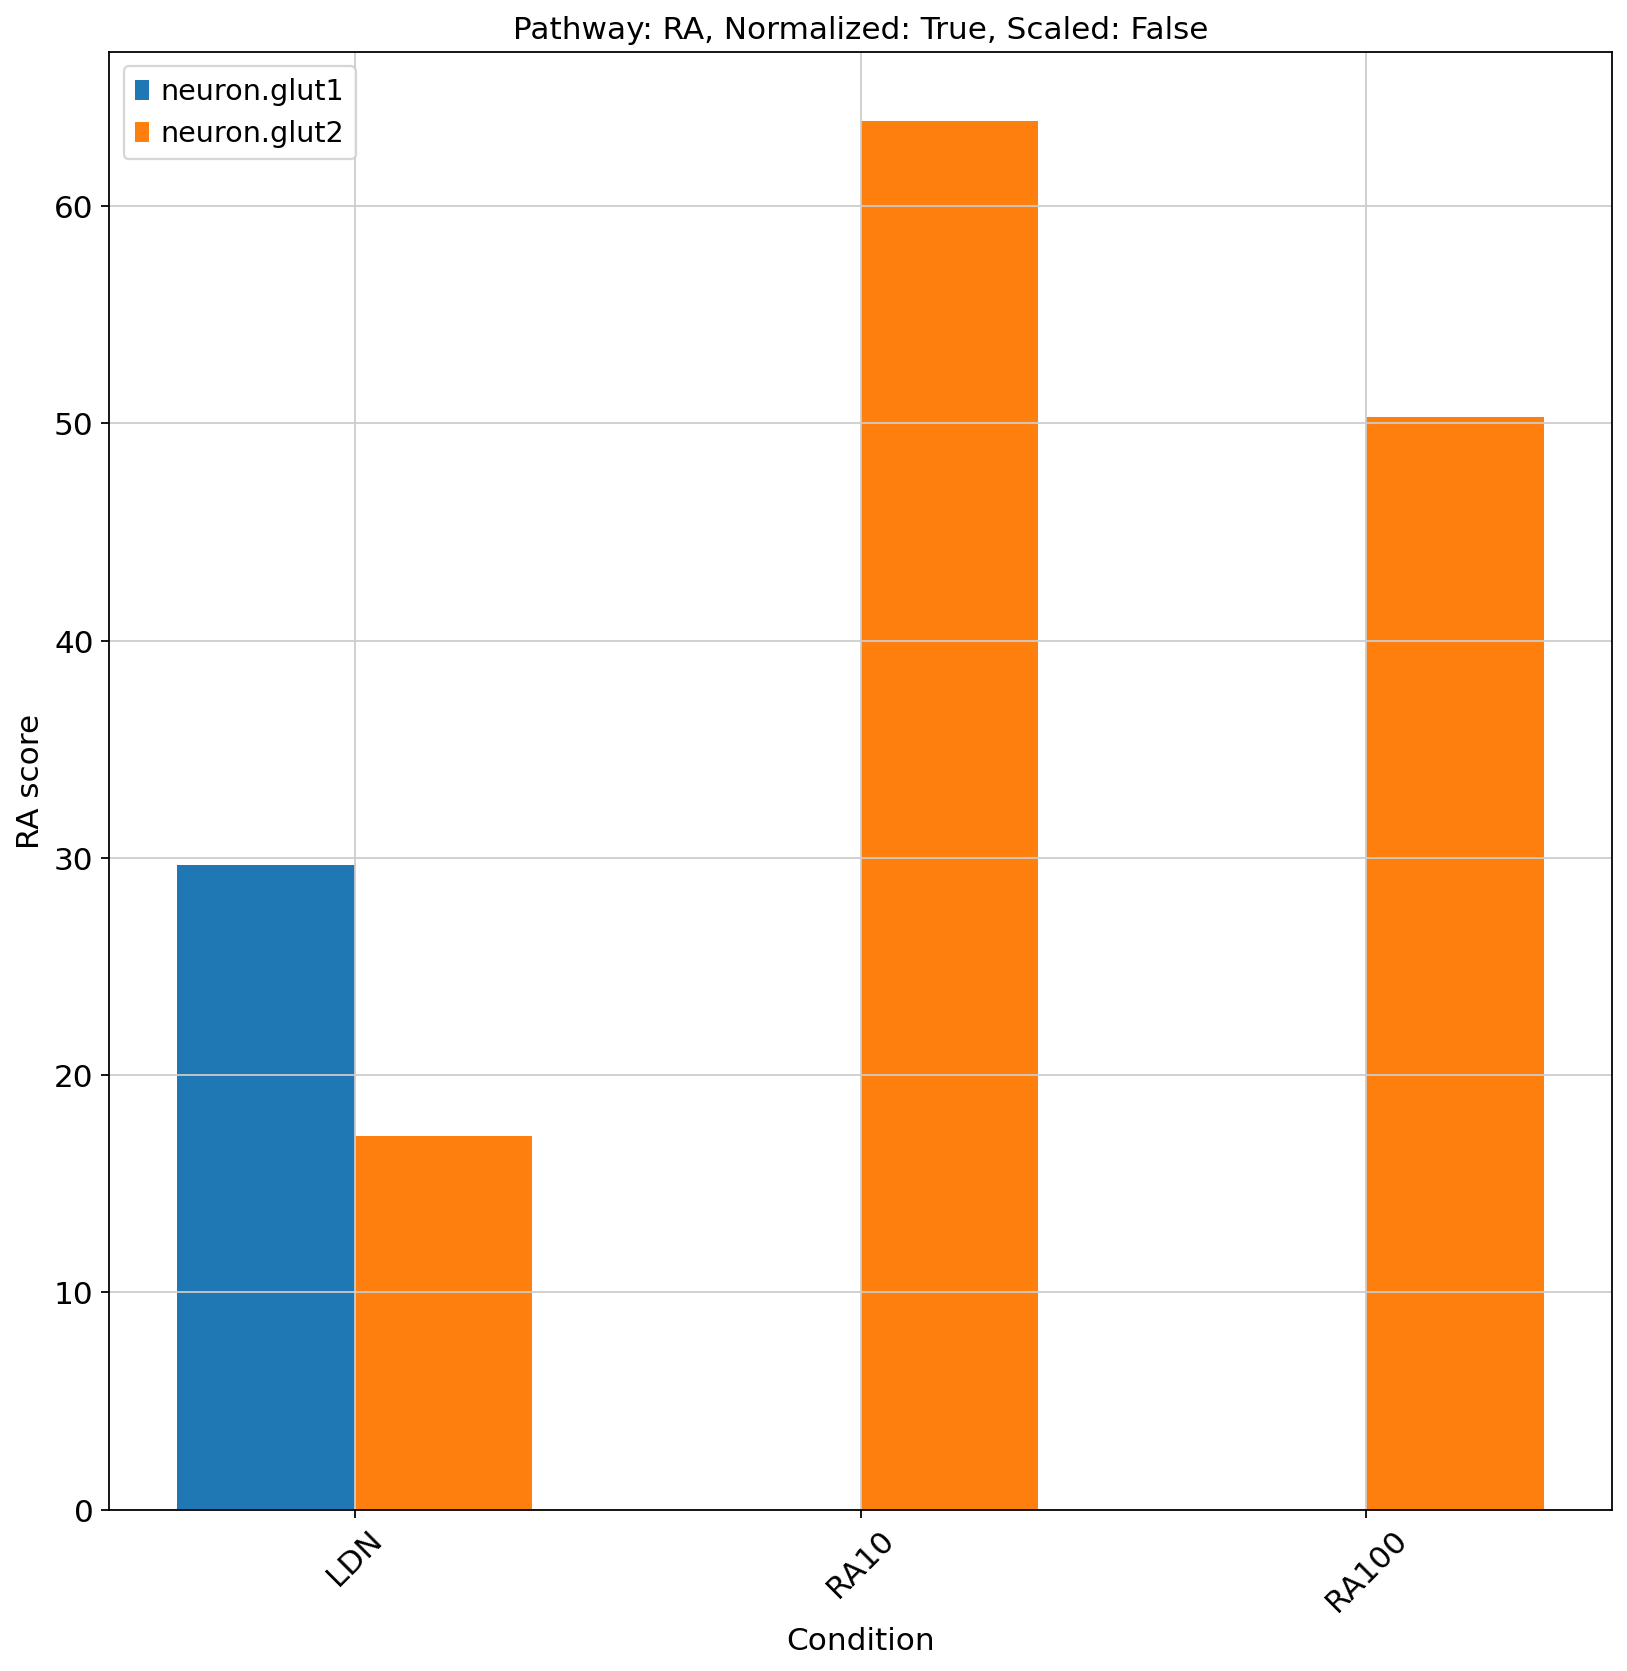

In [36]:
# Create a grid of plots for different configurations
def create_all_plots(data):
    # Define all combinations we want to plot
    pathways = ['SAG', 'RA']
    controls = [True] # [True, False]
    normalize_weights_options = [True] # [True, False]
    scale_by_variance_options = [False] # [True, False]
    scaling_only_based_on_control_options = [False] # [True, False]
    
    # Calculate number of rows and columns for subplots
    total_plots = len(pathways)
    
    # Create plots for each pathway with different configurations
    for pathway in pathways:
        for control in controls:
            # Create a figure with 2x2 subplots for different scaling options
            fig = plt.figure(figsize=(20, 20))
            
            plot_idx = 1
            for normalize_weights in normalize_weights_options:
                for scale_by_variance in scale_by_variance_options:
                    score_of_interest = (
                        f'gene_score_{pathway}_{control}_'
                        f'normalized_{normalize_weights}_'
                        f'scaled_{scale_by_variance}_'
                        f'cc_{"LDN" if control else "None"}_'
                        f'sc_{scaling_only_based_on_control}'
                    )
                    
                    # Filter data for relevant conditions
                    conditions_to_plot = []
                    if pathway == 'SAG':
                        conditions_to_plot = SAG_conditions
                    elif pathway == 'RA':
                        conditions_to_plot = RA_conditions
                    
                    plot_data = data[data['Og_condition'].isin(conditions_to_plot)]
                    
                    ax = plt.subplot(2, 2, plot_idx)
                    
                    # Set width of bars and positions
                    bar_width = 0.35
                    class_types = ['neuron.glut1', 'neuron.glut2']
                    
                    # Use conditions_to_plot to maintain exact order
                    x = np.arange(len(conditions_to_plot))
                    
                    # Plot bars for each class2 type
                    for i, class_type in enumerate(class_types):
                        class_data = plot_data[plot_data['class2'] == class_type]
                        means = [class_data[class_data['Og_condition'] == cond][score_of_interest].mean() 
                               for cond in conditions_to_plot]
                        
                        ax.bar(x + i*bar_width, means, bar_width, 
                              label=class_type)
                    
                    # Customize subplot
                    ax.set_title(f'Pathway: {pathway}, Normalized: {normalize_weights}, Scaled: {scale_by_variance}')
                    ax.set_xlabel('Condition')
                    ax.set_ylabel(f'{pathway} score')
                    ax.set_xticks(x + bar_width/2)
                    ax.set_xticklabels(conditions_to_plot, rotation=45)
                    ax.legend()
                    
                    plot_idx += 1
            
            plt.tight_layout()
            plt.show()
            plt.close()

# Generate all plots
create_all_plots(neurons_aggr.obs)